In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import io

Mnist data loading 

In [100]:
mat = io.loadmat('./data_image_classif.mat')

X = mat['Xts']

df_y = pd.DataFrame(mat['yts'])
y = pd.get_dummies(df_y[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y.shape}')

X_to_predict = pd.DataFrame(mat['Xvr'])

y shape : (60000, 10)


Documents data loading

In [101]:
mat_doc = io.loadmat('./data_doc_classif.mat')

X_doc = mat_doc['Xts'].T.toarray()

df_y_doc = pd.DataFrame(mat_doc['yts'])
y_doc = pd.get_dummies(df_y_doc[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y_doc.shape}')

X_to_predict_doc = pd.DataFrame(mat_doc['Xvr'].T.toarray())



y shape : (13960, 20)


Documents train set

In [10]:
train_set_doc = [[X_doc[i].reshape(1,-1),y_doc[i].reshape(1,-1)] for i in range(X_doc.shape[0])]
len(train_set_doc)

13960

Mnist train set

In [11]:
train_set = [[X[i].reshape(1,-1),y[i].reshape(1,-1)] for i in range(X.shape[0])]
len(train_set)

60000

Functions init

In [12]:
def sig(x):
    
    return 1/(1 + np.exp(-x))

def sig_der(x):
    
    return sig(x)*(1 - sig(x))

def loss(y, y_pred):
    
    return ((y-y_pred)**2).mean()


def loss_batch(y, y_pred):
    
    return np.mean(np.mean(((y-y_pred)**2), axis = 1))



def relu_deriv(t):
    
    return (t >= 0).astype(float)

def relu(t):
    return np.maximum(t,0)

# accuracy
def accuracy(cur_set):
    correct = 0
    
    for x,y in cur_set:
        z = predict_new3(x)
        y_pred = np.argmax(z)
        if y_pred == np.argmax(y):
            correct += 1
#         print(y_pred, np.argmax(y))
    acc = correct / len(cur_set)
    return acc

def accuracy_doc(cur_set, y = None):
    correct = 0
    
    for x,y in cur_set:
        z = predict_new3_doc(x)
        y_pred = np.argmax(z)
        if y_pred == np.argmax(y):
            correct += 1
#         print(y_pred, np.argmax(y))
    acc = correct / len(cur_set)
    return acc

def softmax(t):
    
    out = np.exp(t)
    return out/np.sum(out)

def softmax_batch(t):
    
    out = np.exp(t)
    return out/np.sum(out, axis = 1, keepdims = True)

def stable_softmax(x):
    z = x - np.max(x, axis = 1, keepdims = True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis = 1, keepdims = True)
    softmax = numerator/denominator

    return softmax

def predict_new(x):
    s1 = np.dot(x, W1) + b1
    h1 = relu(s1)

    y_pred = stable_softmax(h1 @ W2 + b2)
    return y_pred

def predict_new3(x):
    s1 = np.dot(x, W1) + b1
    h1 = relu(s1)
    
    s2 = h1 @ W2 + b2
    h2 = relu(s2)

    y_pred = stable_softmax(h2 @ W3 + b3)
    return y_pred

def predict_new3_doc(x):
    s1 = np.dot(x, W1_doc) + b1_doc
    h1 = relu(s1)
    
    s2 = h1 @ W2_doc + b2_doc
    h2 = relu(s2)

    y_pred = stable_softmax(h2 @ W3_doc + b3_doc)
    return y_pred

def soft_deriv(x):

   return stable_softmax(x) * (1 - stable_softmax(x))

Model for prediction the documents

In [13]:
input_size_doc = X_doc.shape[1]
hidden_size1_doc = 500
hidden_size2_doc = 500
output_size_doc = 20
batch_size_doc = 500



W1_doc = np.random.randn(input_size_doc, hidden_size1_doc)
b1_doc = np.random.randn(1, hidden_size1_doc)

W2_doc = np.random.randn(hidden_size1_doc, hidden_size2_doc)
b2_doc = np.random.randn(1, hidden_size2_doc)

W3_doc = np.random.randn(hidden_size2_doc, output_size_doc)
b3_doc = np.random.randn(1, output_size_doc)


loss_list_doc = []

n_iters_batch_doc = len(train_set_doc) // batch_size_doc
learning_rate_doc = 0.01
n_epochs_doc = 30

status_l = True

random.shuffle(train_set_doc) 

for ep in range(n_epochs_doc):
    
    for i in range(n_iters_batch_doc):
        
        
        batch_x, batch_y = zip(*train_set_doc[i*batch_size_doc: (i+1)*batch_size_doc])
        x = np.concatenate(batch_x, axis = 0)
        y = np.concatenate(batch_y, axis = 0)
        
        s1 = np.dot(x, W1_doc) + b1_doc
        h1 = relu(s1)
        
        s2 = h1 @ W2_doc + b2_doc
        h2 = relu(s2)

        y_pred = stable_softmax(h2 @ W3_doc + b3_doc)
        
        
        
        E = loss_batch(y_pred, y)
        loss_list_doc.append(E)
        
        
        # backward pass
        
        # 3 layer
 
        dloss_dS3  = 2*(y_pred - y)/batch_size_doc  #dloss / y_pred 
        
        dloss_dW3 = h2.T @ dloss_dS3
        
        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
        
        dloss_dh2 = dloss_dS3 @ W3_doc.T

        # 2 layer
 
        dloss_dS2  = dloss_dh2*relu_deriv(s2)  #dloss / y_pred 
        
        dloss_dW2 = h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ W2_doc.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*relu_deriv(s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        W1_doc -= learning_rate_doc *dloss_dW1
        b1_doc -= learning_rate_doc *dloss_db1
        W2_doc -= learning_rate_doc *dloss_dW2
        b2_doc -= learning_rate_doc *dloss_db2
        W3_doc -= learning_rate_doc *dloss_dW3
        b3_doc -= learning_rate_doc *dloss_db3
    
        
#         if l < 1.91 and status_l:
#             learning_rate = 0.01
#             status_l = False
#             print(learning_rate)

        print(f'ep: {ep+1}/{n_epochs_doc}, i: {i+1}/{n_iters_batch_doc}, '
              f'loss - {E:.3f}, ' 
              f'norm_W - {np.linalg.norm(W1_doc):.3f}, ' 
              f'norm_dw - {np.linalg.norm(dloss_dW1):.3f}')
    # if ep == 4:
    #   learning_rate = 10
    # print(f'accuracy - {accuracy(train_set)}')
          





ep: 1/30, i: 1/27, loss - 0.095, norm_W - 4667.738, norm_dw - 691.152
ep: 1/30, i: 2/27, loss - 0.092, norm_W - 4667.708, norm_dw - 674.932
ep: 1/30, i: 3/27, loss - 0.095, norm_W - 4667.646, norm_dw - 983.317
ep: 1/30, i: 4/27, loss - 0.092, norm_W - 4667.590, norm_dw - 983.518
ep: 1/30, i: 5/27, loss - 0.091, norm_W - 4667.564, norm_dw - 430.673
ep: 1/30, i: 6/27, loss - 0.093, norm_W - 4667.542, norm_dw - 520.942
ep: 1/30, i: 7/27, loss - 0.090, norm_W - 4667.530, norm_dw - 428.258
ep: 1/30, i: 8/27, loss - 0.088, norm_W - 4667.522, norm_dw - 298.246
ep: 1/30, i: 9/27, loss - 0.089, norm_W - 4667.516, norm_dw - 257.315
ep: 1/30, i: 10/27, loss - 0.087, norm_W - 4667.511, norm_dw - 354.754
ep: 1/30, i: 11/27, loss - 0.086, norm_W - 4667.506, norm_dw - 221.989
ep: 1/30, i: 12/27, loss - 0.087, norm_W - 4667.500, norm_dw - 341.831
ep: 1/30, i: 13/27, loss - 0.088, norm_W - 4667.497, norm_dw - 472.315
ep: 1/30, i: 14/27, loss - 0.085, norm_W - 4667.492, norm_dw - 219.709
ep: 1/30, i: 15

ep: 5/30, i: 11/27, loss - 0.069, norm_W - 4667.361, norm_dw - 47.836
ep: 5/30, i: 12/27, loss - 0.069, norm_W - 4667.361, norm_dw - 53.210
ep: 5/30, i: 13/27, loss - 0.072, norm_W - 4667.360, norm_dw - 53.718
ep: 5/30, i: 14/27, loss - 0.071, norm_W - 4667.359, norm_dw - 50.572
ep: 5/30, i: 15/27, loss - 0.070, norm_W - 4667.359, norm_dw - 56.708
ep: 5/30, i: 16/27, loss - 0.068, norm_W - 4667.359, norm_dw - 50.262
ep: 5/30, i: 17/27, loss - 0.071, norm_W - 4667.358, norm_dw - 52.878
ep: 5/30, i: 18/27, loss - 0.066, norm_W - 4667.358, norm_dw - 46.633
ep: 5/30, i: 19/27, loss - 0.067, norm_W - 4667.357, norm_dw - 44.921
ep: 5/30, i: 20/27, loss - 0.071, norm_W - 4667.357, norm_dw - 49.257
ep: 5/30, i: 21/27, loss - 0.068, norm_W - 4667.356, norm_dw - 47.694
ep: 5/30, i: 22/27, loss - 0.069, norm_W - 4667.356, norm_dw - 46.884
ep: 5/30, i: 23/27, loss - 0.069, norm_W - 4667.355, norm_dw - 46.844
ep: 5/30, i: 24/27, loss - 0.067, norm_W - 4667.355, norm_dw - 46.593
ep: 5/30, i: 25/27, 

ep: 9/30, i: 21/27, loss - 0.055, norm_W - 4667.322, norm_dw - 31.220
ep: 9/30, i: 22/27, loss - 0.053, norm_W - 4667.322, norm_dw - 29.924
ep: 9/30, i: 23/27, loss - 0.055, norm_W - 4667.322, norm_dw - 34.005
ep: 9/30, i: 24/27, loss - 0.054, norm_W - 4667.322, norm_dw - 29.037
ep: 9/30, i: 25/27, loss - 0.057, norm_W - 4667.322, norm_dw - 29.637
ep: 9/30, i: 26/27, loss - 0.058, norm_W - 4667.321, norm_dw - 30.302
ep: 9/30, i: 27/27, loss - 0.056, norm_W - 4667.321, norm_dw - 29.386
ep: 10/30, i: 1/27, loss - 0.058, norm_W - 4667.321, norm_dw - 30.470
ep: 10/30, i: 2/27, loss - 0.057, norm_W - 4667.321, norm_dw - 31.883
ep: 10/30, i: 3/27, loss - 0.053, norm_W - 4667.321, norm_dw - 28.532
ep: 10/30, i: 4/27, loss - 0.057, norm_W - 4667.320, norm_dw - 28.539
ep: 10/30, i: 5/27, loss - 0.054, norm_W - 4667.320, norm_dw - 27.794
ep: 10/30, i: 6/27, loss - 0.051, norm_W - 4667.320, norm_dw - 27.876
ep: 10/30, i: 7/27, loss - 0.057, norm_W - 4667.320, norm_dw - 30.430
ep: 10/30, i: 8/27, 

ep: 14/30, i: 3/27, loss - 0.043, norm_W - 4667.304, norm_dw - 19.630
ep: 14/30, i: 4/27, loss - 0.048, norm_W - 4667.303, norm_dw - 23.185
ep: 14/30, i: 5/27, loss - 0.046, norm_W - 4667.303, norm_dw - 21.530
ep: 14/30, i: 6/27, loss - 0.041, norm_W - 4667.303, norm_dw - 27.276
ep: 14/30, i: 7/27, loss - 0.050, norm_W - 4667.303, norm_dw - 22.042
ep: 14/30, i: 8/27, loss - 0.046, norm_W - 4667.303, norm_dw - 36.193
ep: 14/30, i: 9/27, loss - 0.047, norm_W - 4667.303, norm_dw - 22.625
ep: 14/30, i: 10/27, loss - 0.045, norm_W - 4667.303, norm_dw - 19.778
ep: 14/30, i: 11/27, loss - 0.045, norm_W - 4667.303, norm_dw - 21.299
ep: 14/30, i: 12/27, loss - 0.046, norm_W - 4667.302, norm_dw - 24.499
ep: 14/30, i: 13/27, loss - 0.047, norm_W - 4667.302, norm_dw - 20.963
ep: 14/30, i: 14/27, loss - 0.047, norm_W - 4667.302, norm_dw - 22.171
ep: 14/30, i: 15/27, loss - 0.046, norm_W - 4667.302, norm_dw - 21.856
ep: 14/30, i: 16/27, loss - 0.044, norm_W - 4667.302, norm_dw - 19.588
ep: 14/30, i:

ep: 18/30, i: 11/27, loss - 0.038, norm_W - 4667.292, norm_dw - 16.086
ep: 18/30, i: 12/27, loss - 0.038, norm_W - 4667.292, norm_dw - 18.176
ep: 18/30, i: 13/27, loss - 0.039, norm_W - 4667.292, norm_dw - 17.456
ep: 18/30, i: 14/27, loss - 0.040, norm_W - 4667.292, norm_dw - 19.060
ep: 18/30, i: 15/27, loss - 0.038, norm_W - 4667.292, norm_dw - 15.362
ep: 18/30, i: 16/27, loss - 0.037, norm_W - 4667.292, norm_dw - 18.700
ep: 18/30, i: 17/27, loss - 0.041, norm_W - 4667.292, norm_dw - 18.422
ep: 18/30, i: 18/27, loss - 0.039, norm_W - 4667.292, norm_dw - 17.040
ep: 18/30, i: 19/27, loss - 0.041, norm_W - 4667.292, norm_dw - 15.512
ep: 18/30, i: 20/27, loss - 0.040, norm_W - 4667.292, norm_dw - 17.791
ep: 18/30, i: 21/27, loss - 0.036, norm_W - 4667.292, norm_dw - 17.531
ep: 18/30, i: 22/27, loss - 0.037, norm_W - 4667.292, norm_dw - 17.942
ep: 18/30, i: 23/27, loss - 0.035, norm_W - 4667.291, norm_dw - 15.947
ep: 18/30, i: 24/27, loss - 0.040, norm_W - 4667.291, norm_dw - 15.184
ep: 18

ep: 22/30, i: 19/27, loss - 0.036, norm_W - 4667.285, norm_dw - 12.294
ep: 22/30, i: 20/27, loss - 0.034, norm_W - 4667.285, norm_dw - 14.022
ep: 22/30, i: 21/27, loss - 0.031, norm_W - 4667.285, norm_dw - 13.514
ep: 22/30, i: 22/27, loss - 0.033, norm_W - 4667.285, norm_dw - 15.177
ep: 22/30, i: 23/27, loss - 0.031, norm_W - 4667.285, norm_dw - 14.047
ep: 22/30, i: 24/27, loss - 0.034, norm_W - 4667.285, norm_dw - 11.960
ep: 22/30, i: 25/27, loss - 0.033, norm_W - 4667.285, norm_dw - 12.457
ep: 22/30, i: 26/27, loss - 0.035, norm_W - 4667.285, norm_dw - 13.431
ep: 22/30, i: 27/27, loss - 0.033, norm_W - 4667.285, norm_dw - 11.685
ep: 23/30, i: 1/27, loss - 0.031, norm_W - 4667.284, norm_dw - 14.835
ep: 23/30, i: 2/27, loss - 0.033, norm_W - 4667.284, norm_dw - 14.820
ep: 23/30, i: 3/27, loss - 0.030, norm_W - 4667.284, norm_dw - 12.421
ep: 23/30, i: 4/27, loss - 0.033, norm_W - 4667.284, norm_dw - 13.897
ep: 23/30, i: 5/27, loss - 0.031, norm_W - 4667.284, norm_dw - 13.740
ep: 23/30, 

ep: 26/30, i: 27/27, loss - 0.030, norm_W - 4667.280, norm_dw - 11.914
ep: 27/30, i: 1/27, loss - 0.029, norm_W - 4667.280, norm_dw - 12.626
ep: 27/30, i: 2/27, loss - 0.031, norm_W - 4667.280, norm_dw - 14.340
ep: 27/30, i: 3/27, loss - 0.026, norm_W - 4667.280, norm_dw - 11.490
ep: 27/30, i: 4/27, loss - 0.030, norm_W - 4667.280, norm_dw - 13.024
ep: 27/30, i: 5/27, loss - 0.028, norm_W - 4667.280, norm_dw - 12.714
ep: 27/30, i: 6/27, loss - 0.026, norm_W - 4667.280, norm_dw - 12.865
ep: 27/30, i: 7/27, loss - 0.031, norm_W - 4667.280, norm_dw - 12.115
ep: 27/30, i: 8/27, loss - 0.029, norm_W - 4667.279, norm_dw - 11.612
ep: 27/30, i: 9/27, loss - 0.026, norm_W - 4667.279, norm_dw - 10.233
ep: 27/30, i: 10/27, loss - 0.030, norm_W - 4667.279, norm_dw - 11.887
ep: 27/30, i: 11/27, loss - 0.029, norm_W - 4667.279, norm_dw - 11.598
ep: 27/30, i: 12/27, loss - 0.030, norm_W - 4667.279, norm_dw - 13.357
ep: 27/30, i: 13/27, loss - 0.030, norm_W - 4667.279, norm_dw - 11.788
ep: 27/30, i: 1

In [14]:
accuracy_doc(train_set_doc[:5000])

0.6594

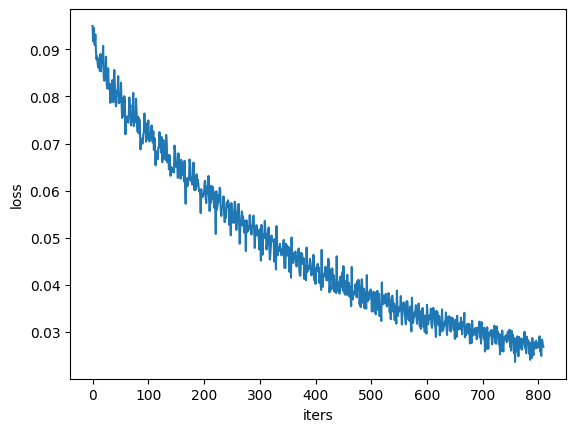

In [15]:
plt.plot(loss_list_doc)
plt.xlabel('iters')
plt.ylabel('loss')
plt.show()

In [16]:
X_to_predict_array_doc = X_to_predict_doc.values
X_to_predict_array_doc.shape

(5989, 43586)

In [125]:
y_predict_doc = []
for i in range(len(X_to_predict_array_doc)):
    y_predict_doc.append(np.argmax(predict_new3_doc(X_to_predict_array_doc[i].reshape(1,-1))))

In [137]:
y_predict_new_doc = [y_predict_doc[i]*100+1 for i in range(len(y_predict_doc))]

In [138]:
y_predict_new_doc_df = pd.DataFrame(np.array(y_predict_new_doc))

In [142]:
df = pd.read_csv('sol_all1.csv')

In [143]:
df

,id,class
0,1,101
1,2,101
2,3,101
3,4,101
4,5,101
...,...,...
5984,5985,101
5985,5986,101
5986,5987,101
5987,5988,101


In [144]:
y_predict_new_doc_df['id'] = df.id

In [145]:
y_predict_new_doc_df['class'] = y_predict_new_doc_df.iloc[:,0]

In [146]:
y_predict_new_doc_df.rename(columns = {0: 'class'}, inplace = True)

In [147]:
y_predict_new_doc_df = y_predict_new_doc_df[['id', 'class']]

In [148]:
y_predict_new_doc_df = y_predict_new_doc_df.iloc[:,:-1]

In [149]:
y_predict_new_doc_df

,id,class
0,1,1301
1,2,1701
2,3,601
3,4,101
4,5,201
...,...,...
5984,5985,401
5985,5986,1201
5986,5987,201
5987,5988,1901


In [151]:
y_predict_new_doc_df.to_csv('Skripkin_doc.csv', index = False)

In [154]:
pd.read_csv('Skripkin_doc.csv')

,id,class
0,1,1301
1,2,1701
2,3,601
3,4,101
4,5,201
...,...,...
5984,5985,401
5985,5986,1201
5986,5987,201
5987,5988,1901


In [155]:
train_set[0][0].shape

(1, 784)

In [103]:
tr_set = train_set[:40000]

In [107]:
input_size = X.shape[1]
hidden_size1 = 392
hidden_size2 = 100
output_size = y.shape[1]
# batch_size = int(X.shape[0] / 3)
batch_size = int(len(tr_set) / 3)



W1 = np.random.randn(input_size, hidden_size1)
b1 = np.random.randn(1, hidden_size1)

W2 = np.random.randn(hidden_size1, hidden_size2)
b2 = np.random.randn(1, hidden_size2)

W3 = np.random.randn(hidden_size2, output_size)
b3 = np.random.randn(1, output_size)


loss_list = []
acc_list = []

# n_iters_batch = len(train_set) // batch_size
n_iters_batch = len(tr_set) // batch_size

learning_rate = 0.00001

n_epochs = 200

status_l = True

random.shuffle(train_set) 

for ep in range(n_epochs):
    
    for i in range(n_iters_batch):
        
        
        batch_x, batch_y = zip(*tr_set[i*batch_size: (i+1)*batch_size])
        x = np.concatenate(batch_x, axis = 0)
        y = np.concatenate(batch_y, axis = 0)
        
        s1 = np.dot(x, W1) + b1
        h1 = relu(s1)
        
        s2 = h1 @ W2 + b2
        h2 = relu(s2)

        # s3 = h2 @ W3 + b3
        # h3 = relu(s3)

        y_pred = stable_softmax(h2 @ W3 + b3)
        
        
        
        E = loss_batch(y_pred, y)
        loss_list.append(E)
        
        
        # 3 layer
      
        dloss_dS3  = 2*(y_pred - y)/batch_size  #dloss / y_pred 

        dloss_dW3 = h2.T @ dloss_dS3
        
        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
        
        dloss_dh2 = dloss_dS3 @ W3.T

        # 2 layer
 
        dloss_dS2  = dloss_dh2*relu_deriv(s2)  #dloss / y_pred 
        
        dloss_dW2 = h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ W2.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*relu_deriv(s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        W1 -= learning_rate *dloss_dW1
        b1 -= learning_rate *dloss_db1
        W2 -= learning_rate *dloss_dW2
        b2 -= learning_rate *dloss_db2
        W3 -= learning_rate *dloss_dW3
        b3 -= learning_rate *dloss_db3
        # W4 -= learning_rate *dloss_dW4
        # b4 -= learning_rate *dloss_db4
    
        
#         if l < 1.91 and status_l:
#             learning_rate = 0.01
#             status_l = False
#             print(learning_rate)

        print(f'ep: {ep+1}/{n_epochs}, i: {i+1}/{n_iters_batch}, '
              f'loss - {E:.3f}, ' 
              f'norm_W - {np.linalg.norm(W1):.3f}, ' 
              f'norm_dw - {np.linalg.norm(dloss_dW1):.3f}')
    # if ep == 4:
    #   learning_rate = 10
    # print(f'accuracy - {accuracy(train_set)}')
          





ep: 1/200, i: 1/3, loss - 0.179, norm_W - 553.372, norm_dw - 114518.479
ep: 1/200, i: 2/3, loss - 0.173, norm_W - 553.365, norm_dw - 85163.617
ep: 1/200, i: 3/3, loss - 0.164, norm_W - 553.359, norm_dw - 66529.155
ep: 2/200, i: 1/3, loss - 0.151, norm_W - 553.355, norm_dw - 46578.287
ep: 2/200, i: 2/3, loss - 0.143, norm_W - 553.351, norm_dw - 34784.797
ep: 2/200, i: 3/3, loss - 0.131, norm_W - 553.348, norm_dw - 30259.243
ep: 3/200, i: 1/3, loss - 0.122, norm_W - 553.345, norm_dw - 25127.419
ep: 3/200, i: 2/3, loss - 0.117, norm_W - 553.343, norm_dw - 20939.265
ep: 3/200, i: 3/3, loss - 0.110, norm_W - 553.340, norm_dw - 18817.827
ep: 4/200, i: 1/3, loss - 0.106, norm_W - 553.338, norm_dw - 17287.611
ep: 4/200, i: 2/3, loss - 0.103, norm_W - 553.336, norm_dw - 15784.988
ep: 4/200, i: 3/3, loss - 0.097, norm_W - 553.334, norm_dw - 14718.451
ep: 5/200, i: 1/3, loss - 0.094, norm_W - 553.332, norm_dw - 14201.943
ep: 5/200, i: 2/3, loss - 0.093, norm_W - 553.331, norm_dw - 12720.759
ep: 5

ep: 39/200, i: 3/3, loss - 0.041, norm_W - 553.250, norm_dw - 2740.421
ep: 40/200, i: 1/3, loss - 0.040, norm_W - 553.249, norm_dw - 2796.226
ep: 40/200, i: 2/3, loss - 0.041, norm_W - 553.249, norm_dw - 2825.705
ep: 40/200, i: 3/3, loss - 0.040, norm_W - 553.248, norm_dw - 2687.594
ep: 41/200, i: 1/3, loss - 0.039, norm_W - 553.248, norm_dw - 2753.150
ep: 41/200, i: 2/3, loss - 0.041, norm_W - 553.248, norm_dw - 2787.036
ep: 41/200, i: 3/3, loss - 0.040, norm_W - 553.247, norm_dw - 2613.134
ep: 42/200, i: 1/3, loss - 0.039, norm_W - 553.247, norm_dw - 2676.431
ep: 42/200, i: 2/3, loss - 0.040, norm_W - 553.246, norm_dw - 2743.553
ep: 42/200, i: 3/3, loss - 0.040, norm_W - 553.246, norm_dw - 2555.573
ep: 43/200, i: 1/3, loss - 0.038, norm_W - 553.245, norm_dw - 2620.130
ep: 43/200, i: 2/3, loss - 0.040, norm_W - 553.245, norm_dw - 2695.848
ep: 43/200, i: 3/3, loss - 0.039, norm_W - 553.244, norm_dw - 2508.127
ep: 44/200, i: 1/3, loss - 0.038, norm_W - 553.244, norm_dw - 2560.941
ep: 44

ep: 78/200, i: 2/3, loss - 0.033, norm_W - 553.205, norm_dw - 1892.414
ep: 78/200, i: 3/3, loss - 0.033, norm_W - 553.205, norm_dw - 1798.261
ep: 79/200, i: 1/3, loss - 0.032, norm_W - 553.205, norm_dw - 1762.660
ep: 79/200, i: 2/3, loss - 0.033, norm_W - 553.205, norm_dw - 1863.707
ep: 79/200, i: 3/3, loss - 0.033, norm_W - 553.204, norm_dw - 1768.059
ep: 80/200, i: 1/3, loss - 0.031, norm_W - 553.204, norm_dw - 1754.231
ep: 80/200, i: 2/3, loss - 0.033, norm_W - 553.204, norm_dw - 1864.784
ep: 80/200, i: 3/3, loss - 0.033, norm_W - 553.203, norm_dw - 1754.927
ep: 81/200, i: 1/3, loss - 0.031, norm_W - 553.203, norm_dw - 1745.200
ep: 81/200, i: 2/3, loss - 0.033, norm_W - 553.203, norm_dw - 1831.302
ep: 81/200, i: 3/3, loss - 0.032, norm_W - 553.202, norm_dw - 1729.875
ep: 82/200, i: 1/3, loss - 0.031, norm_W - 553.202, norm_dw - 1720.888
ep: 82/200, i: 2/3, loss - 0.032, norm_W - 553.202, norm_dw - 1809.404
ep: 82/200, i: 3/3, loss - 0.032, norm_W - 553.201, norm_dw - 1732.950
ep: 83

ep: 116/200, i: 3/3, loss - 0.029, norm_W - 553.174, norm_dw - 1356.183
ep: 117/200, i: 1/3, loss - 0.028, norm_W - 553.174, norm_dw - 1416.912
ep: 117/200, i: 2/3, loss - 0.029, norm_W - 553.174, norm_dw - 1438.693
ep: 117/200, i: 3/3, loss - 0.029, norm_W - 553.174, norm_dw - 1348.975
ep: 118/200, i: 1/3, loss - 0.028, norm_W - 553.173, norm_dw - 1430.539
ep: 118/200, i: 2/3, loss - 0.029, norm_W - 553.173, norm_dw - 1427.161
ep: 118/200, i: 3/3, loss - 0.029, norm_W - 553.173, norm_dw - 1356.307
ep: 119/200, i: 1/3, loss - 0.028, norm_W - 553.173, norm_dw - 1412.136
ep: 119/200, i: 2/3, loss - 0.029, norm_W - 553.173, norm_dw - 1431.703
ep: 119/200, i: 3/3, loss - 0.029, norm_W - 553.172, norm_dw - 1351.002
ep: 120/200, i: 1/3, loss - 0.028, norm_W - 553.172, norm_dw - 1417.286
ep: 120/200, i: 2/3, loss - 0.029, norm_W - 553.172, norm_dw - 1418.537
ep: 120/200, i: 3/3, loss - 0.029, norm_W - 553.172, norm_dw - 1334.884
ep: 121/200, i: 1/3, loss - 0.028, norm_W - 553.171, norm_dw - 1

ep: 154/200, i: 3/3, loss - 0.027, norm_W - 553.150, norm_dw - 1153.913
ep: 155/200, i: 1/3, loss - 0.026, norm_W - 553.150, norm_dw - 1213.933
ep: 155/200, i: 2/3, loss - 0.027, norm_W - 553.150, norm_dw - 1266.462
ep: 155/200, i: 3/3, loss - 0.027, norm_W - 553.149, norm_dw - 1146.244
ep: 156/200, i: 1/3, loss - 0.026, norm_W - 553.149, norm_dw - 1213.511
ep: 156/200, i: 2/3, loss - 0.027, norm_W - 553.149, norm_dw - 1272.764
ep: 156/200, i: 3/3, loss - 0.027, norm_W - 553.149, norm_dw - 1135.315
ep: 157/200, i: 1/3, loss - 0.026, norm_W - 553.149, norm_dw - 1176.547
ep: 157/200, i: 2/3, loss - 0.027, norm_W - 553.149, norm_dw - 1218.841
ep: 157/200, i: 3/3, loss - 0.027, norm_W - 553.148, norm_dw - 1136.208
ep: 158/200, i: 1/3, loss - 0.026, norm_W - 553.148, norm_dw - 1203.910
ep: 158/200, i: 2/3, loss - 0.027, norm_W - 553.148, norm_dw - 1264.930
ep: 158/200, i: 3/3, loss - 0.027, norm_W - 553.148, norm_dw - 1135.681
ep: 159/200, i: 1/3, loss - 0.026, norm_W - 553.148, norm_dw - 1

ep: 192/200, i: 3/3, loss - 0.025, norm_W - 553.130, norm_dw - 1030.129
ep: 193/200, i: 1/3, loss - 0.024, norm_W - 553.130, norm_dw - 1101.661
ep: 193/200, i: 2/3, loss - 0.025, norm_W - 553.130, norm_dw - 1045.255
ep: 193/200, i: 3/3, loss - 0.025, norm_W - 553.129, norm_dw - 1010.863
ep: 194/200, i: 1/3, loss - 0.024, norm_W - 553.129, norm_dw - 1075.152
ep: 194/200, i: 2/3, loss - 0.025, norm_W - 553.129, norm_dw - 1020.084
ep: 194/200, i: 3/3, loss - 0.025, norm_W - 553.129, norm_dw - 1012.643
ep: 195/200, i: 1/3, loss - 0.024, norm_W - 553.129, norm_dw - 1070.277
ep: 195/200, i: 2/3, loss - 0.025, norm_W - 553.129, norm_dw - 1029.340
ep: 195/200, i: 3/3, loss - 0.025, norm_W - 553.128, norm_dw - 1023.764
ep: 196/200, i: 1/3, loss - 0.024, norm_W - 553.128, norm_dw - 1060.269
ep: 196/200, i: 2/3, loss - 0.024, norm_W - 553.128, norm_dw - 990.966
ep: 196/200, i: 3/3, loss - 0.025, norm_W - 553.128, norm_dw - 1014.810
ep: 197/200, i: 1/3, loss - 0.024, norm_W - 553.128, norm_dw - 10

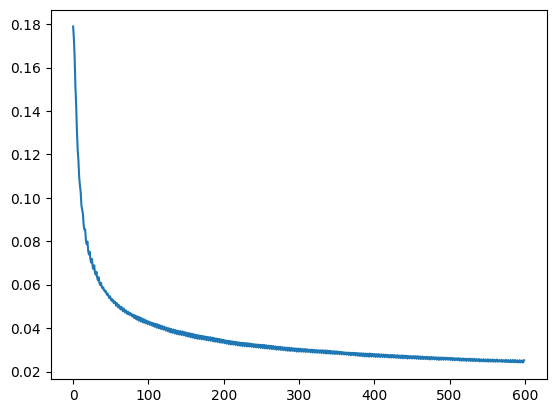

In [108]:
plt.plot(loss_list)

In [109]:
accuracy(train_set[40000:])

0.8766

In [110]:
Xpr = mat['Xvr']

In [111]:
y_predict_ = predict_new3(X_to_predict)

predicted - 4


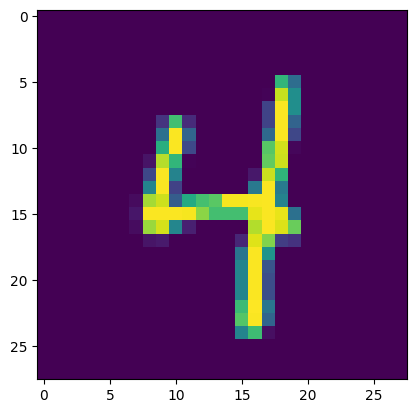

In [131]:
num = 19
print(f'predicted - {np.argmax(y_predict_[num])}')
plt.imshow(Xpr[num].reshape(28,28))
plt.show()

In [171]:
X_to_predict_array = X_to_predict.values
X_to_predict_array.shape

(10000, 784)

In [172]:
y_predict = []
for i in range(len(X_to_predict_array)):
    y_predict.append(np.argmax(predict_new3(X_to_predict_array[i].reshape(1,-1))))

In [173]:
y_predict_new = [y_predict[i]*100+1 for i in range(len(y_predict))]

In [174]:
y_predict_new_df = pd.DataFrame(np.array(y_predict_new))

In [175]:
y_predict_new_df

,0
0,701
1,201
2,101
3,1
4,401
...,...
9995,201
9996,301
9997,401
9998,501


In [39]:
test_df = pd.read_csv('test.csv')
test_df.to_numpy().shape

(28000, 784)

In [194]:
df_ = pd.read_csv('solmnist_exc.csv')

In [196]:
y_predict_new_df['id'] = df_.id
y_predict_new_df['class'] = y_predict_new_df.iloc[:,0]
y_predict_new_df.rename(columns = {0: 'class'}, inplace = True)
y_predict_new_df = y_predict_new_df[['id', 'class']]
y_predict_new_df = y_predict_new_df.iloc[:,:-1]
y_predict_new_df

,id,class
0,1,701
1,2,201
2,3,101
3,4,1
4,5,401
...,...,...
9995,9996,201
9996,9997,301
9997,9998,401
9998,9999,501


In [197]:
y_predict_new_df.to_csv('Skripkin_mnist.csv', index = False)

In [97]:
tr_set = pd.read_csv('train.csv')
tr_set

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
class NeuralNet:

    def __init__(self, h_size1, h_size2,train_set, batch_size = None, learn_rate = 0.00001):
        random.shuffle(train_set)
        self.input_size = train_set[0][0].shape[1]
        self.output_size = train_set[0][1].shape[1]
        self.h_size1 = h_size1
        self.h_size2 = h_size2
        self.train_set = train_set
        self.learn_rate = learn_rate
        if batch_size is not None:
            self.batch_size = batch_size
        else:
            self.batch_size = len(train_set)

        self.w1 = np.random.randn(self.input_size, h_size1)
        self.b1 = np.random.randn(1, h_size1)

        self.w2 = np.random.randn(h_size1, h_size2)
        self.b2 = np.random.randn(1, h_size2)

        self.w3 = np.random.randn(h_size2, self.output_size)
        self.b3 = np.random.randn(1, self.output_size)

        self.n_iters = len(train_set) // self.batch_size

        self.s1 = 0
        self.h1 = 0

        self.h2 = 0
        self.s2 = 0

        self.s3 = 0
        self.h3 = 0

        self.z = 0

    def relu_deriv(self,t):
    
        return (t >= 0).astype(float)

    def relu(self,t):
        return np.maximum(t,0)

    def stable_softmax(self,x):
        z = x - np.max(x, axis = 1, keepdims = True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis = 1, keepdims = True)
        softmax = numerator/denominator
        return softmax


    def forward(self,x):
        self.s1 = np.dot(x, self.w1) + self.b1
#         print(f's1 - {self.s1.shape}')

        self.h1 = self.relu(self.s1)
#         print(f'h1 - {self.h1.shape}')

        self.s2 = np.dot(self.h1, self.w2) + self.b2
#         print(f's2 - {self.s2.shape}')
        
        self.h2 = self.relu(self.s2)
#         print(f'h2 - {self.h2.shape}')

        self.s3 = np.dot(self.h2, self.w3) + self.b3
#         print(f's3 - {self.s3.shape}')

        self.z = self.stable_softmax(self.s3)
#         print(f'z - {self.z.shape}')

        return self.z

    def backward(self,x,y):

        #3 layer

        dloss_dS3  = 2*(self.z - y)/self.batch_size  
#         print(f'dloss_dS3 - {dloss_dS3.shape}')

        dloss_dW3 = self.h2.T @ dloss_dS3
#         print(f'dloss_dW3 - {dloss_dW3.shape}')

        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
#         print(f'dloss_db3 - {dloss_db3.shape}')

        dloss_dh2 = dloss_dS3 @ self.w3.T
#         print(f'dloss_dh2 - {dloss_dh2.shape}')

        # 2 layer
 
        dloss_dS2  = dloss_dh2 * (self.relu_deriv(self.s2)) 
        
        dloss_dW2 = self.h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ self.w2.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*self.relu_deriv(self.s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        self.w1 = self.w1 - self.learn_rate *dloss_dW1
        self.b1 = self.b1 - self.learn_rate *dloss_db1
        
        self.w2 = self.w2 - self.learn_rate *dloss_dW2
        self.b2 = self.b2 - self.learn_rate *dloss_db2

        self.w3 = self.w3 - self.learn_rate *dloss_dW3
        self.b3 = self.b3 - self.learn_rate *dloss_db3


    def parameters(self):

        return self.w1, self.b1, self.w2, self.b2,self.w3, self.b3

    def loss_batch(self, y):
    
        return np.mean(np.mean(((y-self.z)**2), axis = 1))


  



In [94]:
n = NeuralNet(392,100, train_set, batch_size = 100, learn_rate = 0.1)

In [96]:
n_epochs = 40
for ep in range(1):

    for i in range(10):
        X,y = n.train_set[i]
        print(n.z)
        n.forward(X)
#         print(f'ep: {ep+1}/{n_epochs}, i: {i+1}/{n.n_iters}, '
#               f'loss - {n.loss_batch(y):.3f}, ')
        n.backward(X,y)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.02513016 0.0578839  0.28061741 0.02717514 0.0204489  0.0243028
  0.09131688 0.12196513 0.21911862 0.13204106]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [89]:
class Check:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def change(self):
        self.x = self.x **2
        self.y = self.y **2

In [90]:
ch = Check(2,2)

In [91]:
for i in range(4):
    ch.change()
    print(ch.x, ch.y)

4 4
16 16
256 256
65536 65536
